In [1]:
!pip install -Uqqq pip --progress-bar off
!pip install -qqq langchain-groq==0.1.9 --progress-bar off
!pip install -qqq langgraph==0.2.14 --progress-bar off
!pip install -qqq openbb==4.3.1 --progress-bar off
!pip install -qqq duckduckgo-search==6.2.11 --progress-bar off
!pip install -qqq pandas_ta==0.3.14b --progress-bar off

  Preparing metadata (setup.py) ... done


In [2]:
import sqlite3
import textwrap
from enum import Enum, auto
from typing import Annotated, List, Literal, TypedDict

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pandas_ta as ta
from duckduckgo_search import DDGS
from google.colab import userdata
from IPython.display import Image, display
from langchain_core.messages import HumanMessage
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_groq import ChatGroq
from langgraph.graph import END, StateGraph
from openbb import obb

np.random.seed(42)

# MODEL = "llama3-groq-70b-8192-tool-use-preview"
MODEL = "llama-3.1-70b-versatile"
DB_NAME = "crypto_gpt.db"

llm = ChatGroq(temperature=0, model_name=MODEL, api_key=userdata.get("GROQ_API_KEY"))
obb.account.login(pat=userdata.get("OPENBB_API_KEY"))
obb.user.preferences.output_type = "dataframe"

Extensions to add: yfinance@1.3.2
Extensions to remove: yfinance@1.3.1

Building...


## Save Data

In [3]:
def get_connection():
    return sqlite3.connect(DB_NAME)


db_connection = get_connection()

In [4]:
money_df = obb.economy.money_measures(start_date="2010-01-01")
money_df.month = pd.to_datetime(money_df.month)
money_df.head()

/usr/local/lib/python3.10/dist-packages/openbb_federal_reserve/models/money_measures.py:92: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: float(x) if x != "-" and x is not None else x)


,month,M1,M2,currency,demand_deposits,retail_money_market_funds,small_denomination_time_deposits,other_liquid_deposits
0,2010-01-01,1674.2,8464.4,860.6,436.0,796.9,1163.6,NaN
1,2010-02-01,1685.2,8508.4,869.8,438.4,787.3,1142.3,NaN
2,2010-03-01,1729.5,8576.6,875.7,458.8,770.7,1119.7,NaN
3,2010-04-01,1716.0,8601.8,879.4,453.4,747.3,1097.8,NaN
4,2010-05-01,1708.2,8584.2,882.5,450.5,736.4,1075.0,NaN


In [5]:
money_df = money_df[["month", "M1", "M2"]]
money_df.columns = ["date", "m1", "m2"]
money_df.head()

,date,m1,m2
0,2010-01-01,1674.2,8464.4
1,2010-02-01,1685.2,8508.4
2,2010-03-01,1729.5,8576.6
3,2010-04-01,1716.0,8601.8
4,2010-05-01,1708.2,8584.2


In [6]:
money_df.to_sql("money_supply", db_connection)

175

In [7]:
btc_df = obb.crypto.price.historical(symbol="BTCUSD", start_date="2010-01-01")
eth_df = obb.crypto.price.historical(symbol="ETHUSD", start_date="2010-01-01")
sol_df = obb.crypto.price.historical(symbol="SOLUSD", start_date="2010-01-01")

In [8]:
btc_df.head()

,open,high,low,close,volume
date,,,,,
2014-09-17,465.864014,468.174011,452.421997,457.334015,21056800.0
2014-09-18,456.859985,456.859985,413.104004,424.440002,34483200.0
2014-09-19,424.102997,427.834991,384.532013,394.795990,37919700.0
2014-09-20,394.673004,423.295990,389.882996,408.903992,36863600.0
2014-09-21,408.084991,412.425995,393.181000,398.821014,26580100.0


In [9]:
btc_df["date"] = pd.to_datetime(btc_df.index)
btc_df["ticker"] = "BTC"

eth_df["date"] = pd.to_datetime(eth_df.index)
eth_df["ticker"] = "ETH"

sol_df["date"] = pd.to_datetime(sol_df.index)
sol_df["ticker"] = "SOL"

In [10]:
price_df = pd.concat([btc_df, eth_df, sol_df], axis=0).reset_index(drop=True)
price_df.head()

,open,high,low,close,volume,date,ticker
0,465.864014,468.174011,452.421997,457.334015,21056800.0,2014-09-17,BTC
1,456.859985,456.859985,413.104004,424.440002,34483200.0,2014-09-18,BTC
2,424.102997,427.834991,384.532013,394.795990,37919700.0,2014-09-19,BTC
3,394.673004,423.295990,389.882996,408.903992,36863600.0,2014-09-20,BTC
4,408.084991,412.425995,393.181000,398.821014,26580100.0,2014-09-21,BTC


In [11]:
price_df = price_df[["date", "ticker", "open", "high", "low", "close", "volume"]]
price_df = price_df.sort_values(by="date").reset_index(drop=True)
price_df.tail()

,date,ticker,open,high,low,close,volume
7722,2024-08-29,BTC,59027.468750,61184.082031,58786.226562,59388.179688,3.222499e+10
7723,2024-08-29,SOL,143.891068,147.220581,138.266068,140.054031,2.098252e+09
7724,2024-08-30,BTC,59374.441406,59781.671875,57925.195312,58859.777344,3.366401e+10
7725,2024-08-30,ETH,2528.342529,2538.271484,2441.317871,2509.927490,1.597369e+10
7726,2024-08-30,SOL,140.053619,140.997818,132.659454,136.345306,2.761629e+09


In [12]:
price_df.to_sql("prices", db_connection)

7727

In [13]:
def search(keyword: str, max_results=100) -> pd.DataFrame:
    search_tool = DDGS()
    results = search_tool.news(
        keywords=keyword, safesearch="off", timelimit="m", max_results=max_results
    )
    df = pd.DataFrame.from_records(results)
    df["date"] = pd.to_datetime(df.date)
    return df.sort_values(by="date", ascending=False)

In [14]:
crypto_news_df = search(keyword="Cryptocurrency")
btc_news_df = search(keyword="Bitcoin")
eth_news_df = search(keyword="Ethereum")
sol_news_df = search(keyword="Solana")
crypto_news_df.shape, btc_news_df.shape, eth_news_df.shape, sol_news_df.shape

((100, 6), (100, 6), (100, 6), (100, 6))

In [15]:
crypto_news_df["ticker"] = None
btc_news_df["ticker"] = "BTC"
eth_news_df["ticker"] = "ETH"
sol_news_df["ticker"] = "SOL"

In [16]:
news_df = pd.concat([crypto_news_df, btc_news_df, eth_news_df, sol_news_df], axis=0)
news_df = news_df.sort_values(by="date").reset_index(drop=True)
news_df.head()

,date,title,body,url,image,source,ticker
0,2024-08-01 00:00:00+00:00,Bitcoin Goes All In With Trump,With 10 senators and Trump in attendance at th...,https://www.thenation.com/article/politics/bit...,,The Nation,BTC
1,2024-08-01 02:01:00+00:00,"No, Bitcoin Won't Solve Our National Debt","At a Bitcoin conference last weekend, Senator ...",https://www.forbes.com/sites/benritz/2024/07/3...,,Forbes,BTC
2,2024-08-01 15:19:00+00:00,Trump's big cryptocurrency bet,"Former President Donald Trump, who once called...",https://www.cbsnews.com/news/trump-cryptocurre...,,CBS News,None
3,2024-08-01 20:58:00+00:00,FBI Issues New Warning If You Buy Crypto From ...,With the billions of dollars held by cryptocur...,https://www.forbes.com/sites/zakdoffman/2024/0...,,Forbes,None
4,2024-08-02 09:00:00+00:00,"Ethereum price today: ETH is trading at $3,153.45",The return comparisons are as of 8 a.m. ET. Al...,https://www.usatoday.com/money/blueprint/inves...,,USA Today,ETH


In [17]:
news_df.to_sql("news", db_connection)

400

## Historical Prices

In [18]:
class Ticker(Enum):
    BTC = auto()
    ETH = auto()
    SOL = auto()


class TimeFrame(Enum):
    DAILY = auto()
    WEEKLY = auto()
    MONTHLY = auto()


def get_price_data(
    ticker: Ticker, time_frame: TimeFrame = TimeFrame.DAILY
) -> pd.DataFrame:
    query = """
    SELECT date, high, low, close, volume
    FROM prices
    WHERE ticker=?
    ORDER BY date"""
    with get_connection() as connection:
        df = pd.read_sql(
            query,
            connection,
            params=[ticker.name],
            index_col="date",
            parse_dates=["date"],
        )
        if time_frame == TimeFrame.DAILY:
            return df
        interval = "W" if time_frame == TimeFrame.WEEKLY else "M"
        return df.resample(interval).agg(
            {"high": "max", "low": "min", "close": "last", "volume": "sum"}
        )


def get_money_supply() -> pd.DataFrame:
    query = """
    SELECT date, m1, m2
    FROM money_supply
    ORDER BY date
    """
    with get_connection() as connection:
        return pd.read_sql(query, connection, index_col="date", parse_dates=["date"])

In [19]:
money_supply_df = get_money_supply()
money_supply_df.head()

,m1,m2
date,,
2010-01-01,1674.2,8464.4
2010-02-01,1685.2,8508.4
2010-03-01,1729.5,8576.6
2010-04-01,1716.0,8601.8
2010-05-01,1708.2,8584.2


In [20]:
eth_weekly_df = get_price_data(Ticker.ETH, time_frame=TimeFrame.WEEKLY)
eth_weekly_df.head()

,high,low,close,volume
date,,,,
2017-11-12,329.451996,294.541992,307.907990,4.235017e+09
2017-11-19,371.290985,307.024994,354.385986,6.084392e+09
2017-11-26,485.191986,350.692993,471.329987,9.316128e+09
2017-12-03,522.307007,401.243011,465.852997,1.050405e+10
2017-12-10,504.147003,414.411011,441.721008,1.209451e+10


## News

In [21]:
def get_news_data(ticker: Ticker, max_articles_per_day: int = 5) -> pd.DataFrame:
    query = """
    SELECT date, title, body
    FROM news
    WHERE ticker=? OR ticker IS NULL
    ORDER BY date
    """
    with get_connection() as connection:
        df = pd.read_sql(
            query,
            connection,
            params=[ticker.name],
            index_col="date",
            parse_dates=["date"],
        )
        groups = [
            group.sample(min(len(group), max_articles_per_day))
            for _, group in df.groupby(df.index.date)
        ]
        return pd.concat(groups)

In [22]:
btc_news_df = get_news_data(Ticker.BTC)
btc_news_df.shape

(69, 2)

In [23]:
btc_news_df.head()

,title,body
date,,
2024-08-01 02:01:00+00:00,"No, Bitcoin Won't Solve Our National Debt","At a Bitcoin conference last weekend, Senator ..."
2024-08-01 20:58:00+00:00,FBI Issues New Warning If You Buy Crypto From ...,With the billions of dollars held by cryptocur...
2024-08-01 00:00:00+00:00,Bitcoin Goes All In With Trump,With 10 senators and Trump in attendance at th...
2024-08-01 15:19:00+00:00,Trump's big cryptocurrency bet,"Former President Donald Trump, who once called..."
2024-08-02 11:30:00+00:00,Pump and Trump,There were rumors that Elon Musk would introdu...


## Indicators

In [24]:
dates = pd.date_range(start="2023-01-01", periods=100, freq="D")
price = np.cumsum(np.random.randn(100)) + 100  # Random walk

df = pd.DataFrame({"Date": dates, "Price": price})
df.set_index("Date", inplace=True)

### RSI

In [25]:
def calculate_rsi(data, periods=14):
    delta = data.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=periods).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=periods).mean()

    rs = gain / loss
    return 100 - (100 / (1 + rs))


df["RSI"] = calculate_rsi(df["Price"])

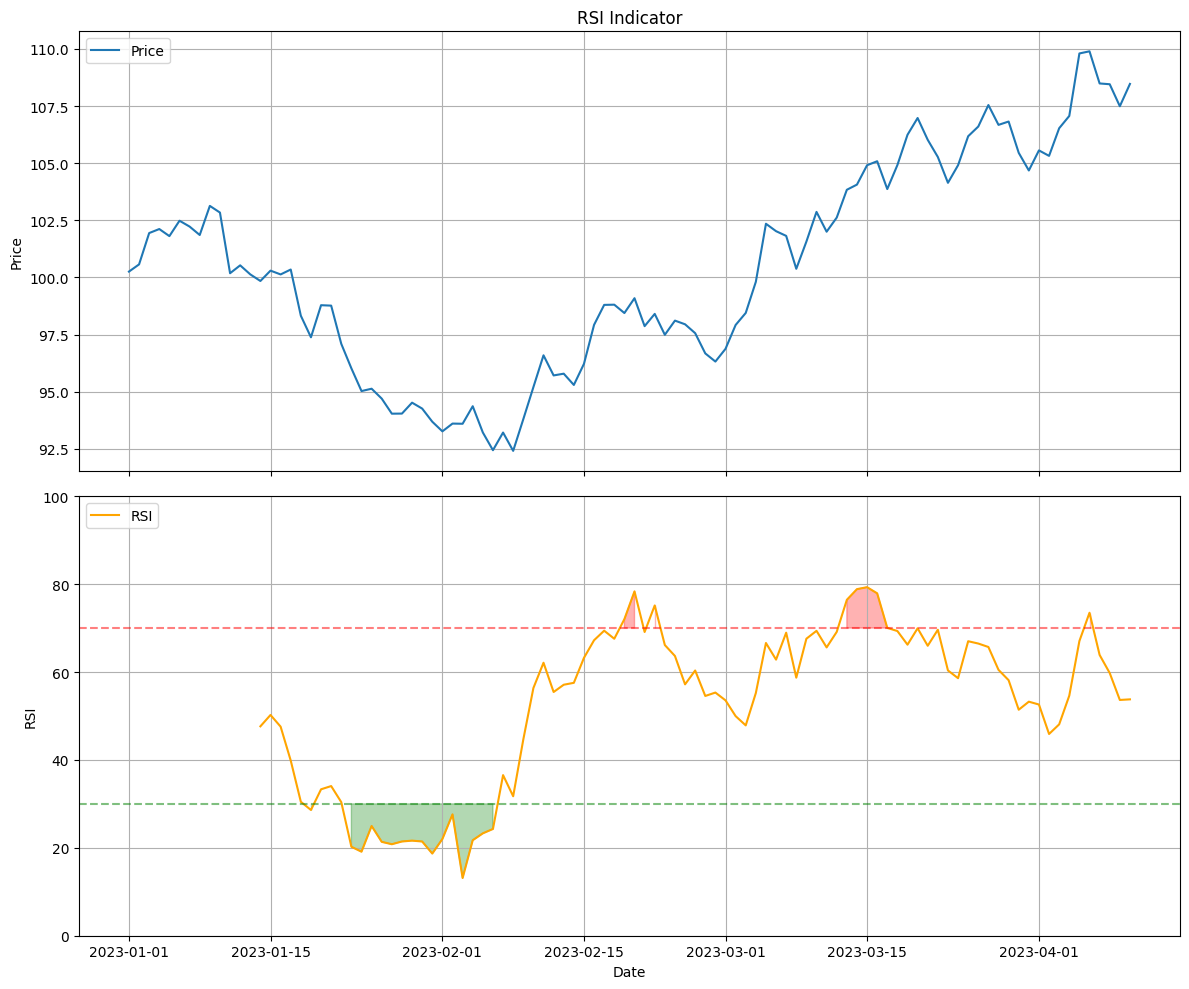

In [26]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

ax1.plot(df.index, df["Price"], label="Price")
ax1.set_title("RSI Indicator")
ax1.set_ylabel("Price")
ax1.legend(loc="upper left")
ax1.grid(True)

ax2.plot(df.index, df["RSI"], label="RSI", color="orange")
ax2.axhline(y=70, color="red", linestyle="--", alpha=0.5)
ax2.axhline(y=30, color="green", linestyle="--", alpha=0.5)
ax2.fill_between(
    df.index, df["RSI"], 70, where=(df["RSI"] >= 70), color="red", alpha=0.3
)
ax2.fill_between(
    df.index, df["RSI"], 30, where=(df["RSI"] <= 30), color="green", alpha=0.3
)
ax2.set_ylabel("RSI")
ax2.set_ylim(0, 100)
ax2.legend(loc="upper left")
ax2.grid(True)

plt.xlabel("Date")
plt.tight_layout()
plt.show()

### Bollinger Bands

In [27]:
window = 20
df["SMA"] = df["Price"].rolling(window=window).mean()
df["STD"] = df["Price"].rolling(window=window).std()
df["Upper"] = df["SMA"] + (df["STD"] * 2)
df["Lower"] = df["SMA"] - (df["STD"] * 2)

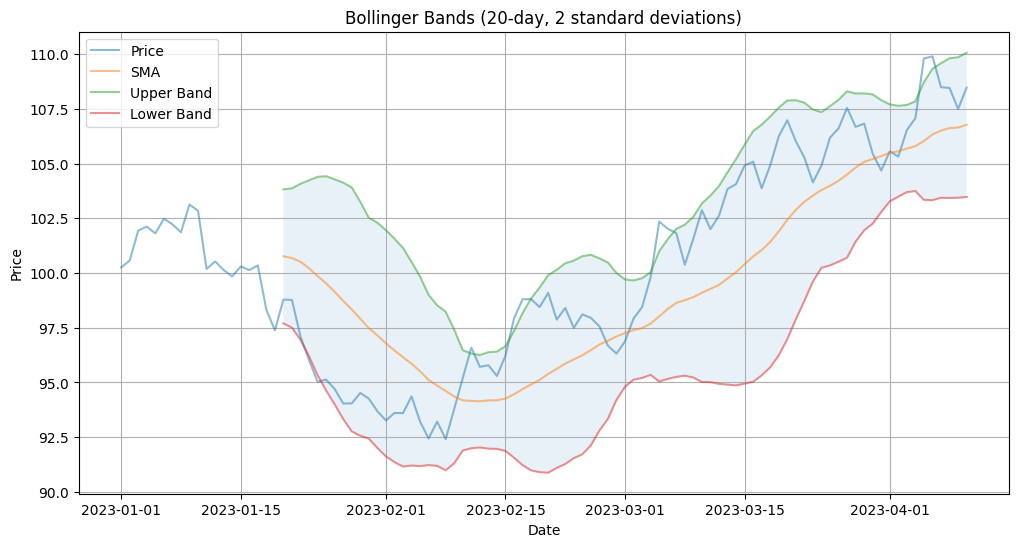

In [28]:
plt.figure(figsize=(12, 6))
plt.plot(df.index, df["Price"], label="Price", alpha=0.5)
plt.plot(df.index, df["SMA"], label="SMA", alpha=0.5)
plt.plot(df.index, df["Upper"], label="Upper Band", alpha=0.5)
plt.plot(df.index, df["Lower"], label="Lower Band", alpha=0.5)
plt.fill_between(df.index, df["Upper"], df["Lower"], alpha=0.1)
plt.title("Bollinger Bands (20-day, 2 standard deviations)")
plt.legend(loc="upper left")
plt.xlabel("Date")
plt.ylabel("Price")
plt.grid(True)
plt.show()

### MACD

In [29]:
df["EMA12"] = df["Price"].ewm(span=12, adjust=False).mean()
df["EMA26"] = df["Price"].ewm(span=26, adjust=False).mean()

df["MACD"] = df["EMA12"] - df["EMA26"]
df["Signal Line"] = df["MACD"].ewm(span=9, adjust=False).mean()
df["Histogram"] = df["MACD"] - df["Signal Line"]

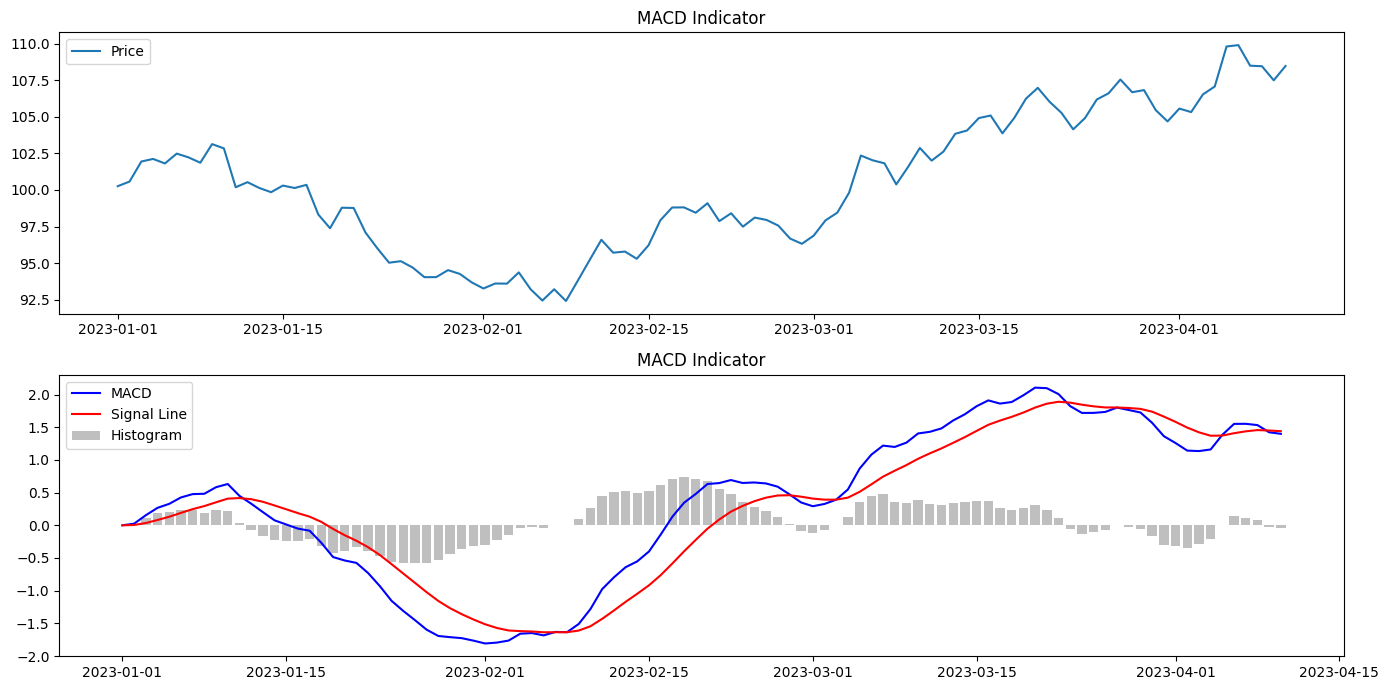

In [30]:
plt.figure(figsize=(14, 7))

plt.subplot(2, 1, 1)
plt.plot(df.index, df["Price"], label="Price")
plt.title("MACD Indicator")
plt.legend(loc="upper left")

plt.subplot(2, 1, 2)
plt.plot(df.index, df["MACD"], label="MACD", color="blue")
plt.plot(df.index, df["Signal Line"], label="Signal Line", color="red")
plt.bar(df.index, df["Histogram"], label="Histogram", color="gray", alpha=0.5)
plt.title("MACD Indicator")
plt.legend(loc="upper left")

plt.tight_layout()
plt.show();

In [31]:
def add_indicators(data: pd.DataFrame) -> pd.DataFrame:
    data = data.copy()
    macd_df = ta.macd(data["close"])
    bbands_df = ta.bbands(data["close"])

    data["ma_50"] = data["close"].rolling(50).mean()
    data["ma_200"] = data["close"].rolling(200).mean()
    data["rsi"] = ta.rsi(data["close"])
    data["macd"], data["macd_signal"], data["macd_histogram"] = (
        macd_df.iloc[:, 0],
        macd_df.iloc[:, 1],
        macd_df.iloc[:, 2],
    )
    data["bb_lower"], data["bb_middle"], data["bb_upper"] = (
        bbands_df.iloc[:, 0],
        bbands_df.iloc[:, 1],
        bbands_df.iloc[:, 2],
    )
    return data

In [32]:
add_indicators(eth_weekly_df).tail()

,high,low,close,volume,ma_50,ma_200,rsi,macd,macd_signal,macd_histogram,bb_lower,bb_middle,bb_upper
date,,,,,,,,,,,,,
2024-08-04,3396.625732,2639.566650,2686.398926,1.291176e+11,2674.547463,2236.663028,42.933270,106.353238,-104.377164,210.730402,2543.456667,3133.587061,3723.717454
2024-08-11,2721.954590,2122.546143,2553.252197,1.823062e+11,2692.462246,2247.553579,41.169057,43.290933,-133.951575,177.242508,2308.900084,3058.360059,3807.820033
2024-08-18,2775.281006,2513.394043,2613.357178,9.936671e+10,2712.007036,2258.729296,42.321282,-1.815501,-143.246407,141.430906,2139.202792,2932.215674,3725.228556
2024-08-25,2820.020508,2538.657715,2749.157715,8.670627e+10,2734.653613,2270.443996,44.944923,-26.301518,-134.185939,107.884421,2260.687068,2774.726123,3288.765178
2024-09-01,2763.004150,2401.175049,2509.927490,8.059070e+10,2752.394229,2281.011842,41.374491,-64.269880,-137.723441,73.453561,2448.806177,2622.418701,2796.031225


In [33]:
def calculate_50_percent(data: pd.DataFrame, n_weeks: int = 4):
    last_n_weeks = data.tail(n=n_weeks)
    low = last_n_weeks.low.min()
    high = last_n_weeks.high.max()
    return (low + high) / 2, low, high

## Graph

### State

In [34]:
class TickerQuery(BaseModel):
    """Ticker symbol requested by the user"""

    ticker: Literal["BTC", "ETH", "SOL"] = Field(
        description="Ticker symbol for the chosen cryptocurrency",
    )


class FinalReport(BaseModel):
    """Report created by the financial reporter"""

    action: Literal["BUY", "HODL", "SELL"] = Field(
        description="Action to take with the chosen cryptocurrency"
    )
    score: int = Field(
        description="Bullishness market score between 0 (extremely bearish) and 100 (extremely bullish)"
    )
    trend: Literal["UP", "NEUTRAL", "DOWN"] = Field(
        description="Price trend for the chosen cryptocurrency",
    )
    sentiment: Literal["GREED", "NEUTRAL", "FEAR"] = Field(
        description="Sentiment from the news for the chosen cryptocurrency"
    )
    price_predictions: List[float] = Field(
        description="Price predictions for 1, 2, 3 and 4 weeks ahead"
    )
    summary: str = Field(
        description="Summary of the current market conditions (1-3 sentences)"
    )


class AppState(TypedDict):
    user_query: str
    ticker: Ticker
    news: pd.DataFrame
    prices: pd.DataFrame
    price_analyst_report: str
    news_analyst_report: str
    final_report: FinalReport

### Nodes

In [35]:
def ticker_extractor(state: AppState):
    ticker_extractor_llm = llm.with_structured_output(TickerQuery)
    extraction = ticker_extractor_llm.invoke([HumanMessage(state["user_query"])])
    return {"ticker": Ticker[extraction.ticker]}

In [36]:
def news_retriever(state: AppState):
    ticker = state["ticker"]
    news_df = get_news_data(ticker)
    return {"news": news_df}

In [37]:
def price_retriever(state: AppState):
    ticker = state["ticker"]
    price_df = get_price_data(ticker, time_frame=TimeFrame.WEEKLY)
    price_df = add_indicators(price_df)
    price_df = price_df.tail(n=24)
    return {"prices": price_df}

In [38]:
def price_analyst(state: AppState):

    price_df = state["prices"]
    weeks_4_50_percent, _, _ = calculate_50_percent(price_df, n_weeks=4)
    weeks_12_50_percent, _, _ = calculate_50_percent(price_df, n_weeks=12)
    weeks_26_50_percent, _, _ = calculate_50_percent(price_df, n_weeks=26)

    money_supply_df = get_money_supply()
    money_supply_text = str(money_supply_df["m2"])

    prompt = f"""You have extensive knowledge of the cryptocurrency market and historical data.
Think step-by-step and focus on the technical indicators.
Use the following weekly close price history and technical indicators for ETH:

price history:
```
{str(price_df[price_df.columns[2:]])}
```

M2 money supply history:
```
{money_supply_text}
```

4 weeks 50% level: {weeks_4_50_percent}
12 weeks 50% level: {weeks_12_50_percent}
26 weeks 50% level: {weeks_26_50_percent}

Predict the next 4 weekly prices based on the data. Put the predictions on separate line.
How certain are you of your predictions? Use a number between 0 (not certain at all) to 10 (sure thing).
What is the overall trend outlook? Explain your predictions in 1-3 sentences.

When creating your answer, focus on answering the user query:
{state["user_query"]}
"""
    response = llm.invoke([HumanMessage(prompt)])
    return {"price_analyst_report": response.content}

In [39]:
def news_analyst(state: AppState):
    news_df = state["news"]
    news_text = ""
    for date, row in list(news_df.iterrows())[:20]:
        news_text += f"{date}\n{row.title}\n{row.body}\n---\n"

    prompt = f"""Choose a combined sentiment that best represents these news articles:

```
{news_text}
```

Each article is separated by `---`.

Pick a number for the sentiment between 0 and 100 where:

- 0 is extremely bearish
- 100 is extremely bullish

Reply only with the sentiment and a short explanation (1-2 sentences) of why.

When creating your answer, focus on answering the user query:
{state["user_query"]}
"""
    response = llm.invoke([HumanMessage(prompt)])
    return {"news_analyst_report": response.content}

In [40]:
def financial_reporter(state: AppState):
    price_report = state["price_analyst_report"]
    news_report = state["news_analyst_report"]
    prompt = f"""You're a senior cryptocurrency expert that makes extremely accurate predictions
about future prices and trend in the crypto market. You're well versed into technological advancements
and tokenomics of various projects.

You're working with two other agents that have created reports of the current state of the crypto market.

Report of the news analyst:

```
{news_report}
```

Report of the price analyst:

```
{price_report}
```

Based on the provided information, create a final report for the user.

When creating your answer, focus on answering the user query:
{state["user_query"]}
"""
    final_report_llm = llm.with_structured_output(FinalReport)
    response = final_report_llm.invoke([HumanMessage(prompt)])
    return {"final_report": response}

### Building the Graph

In [41]:
graph = StateGraph(AppState)

In [42]:
graph.add_node("ticker_extractor", ticker_extractor)
graph.add_node("news_retriever", news_retriever)
graph.add_node("price_retriever", price_retriever)
graph.add_node("price_analyst", price_analyst)
graph.add_node("news_analyst", news_analyst)
graph.add_node("financial_reporter", financial_reporter)

In [43]:
graph.add_edge("ticker_extractor", "price_retriever")
graph.add_edge("ticker_extractor", "news_retriever")
graph.add_edge("news_retriever", "news_analyst")
graph.add_edge("price_retriever", "price_analyst")
graph.add_edge("price_analyst", "financial_reporter")
graph.add_edge("news_analyst", "financial_reporter")

graph.set_entry_point("ticker_extractor")
graph.set_finish_point("financial_reporter")

In [44]:
app = graph.compile()

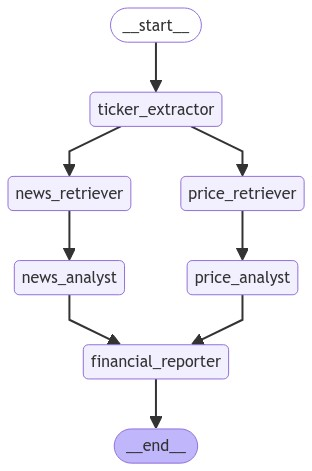

In [45]:
display(Image(app.get_graph().draw_mermaid_png()))

## Use the Graph

In [46]:
config = {"configurable": {"thread_id": 42}}

state = app.invoke(
    {"user_query": "Analyze the long-term potential of Ethereum"},
    config=config,
)

In [47]:
print(state.keys())

dict_keys(['user_query', 'ticker', 'news', 'prices', 'price_analyst_report', 'news_analyst_report', 'final_report'])


In [48]:
for line in state["price_analyst_report"].split("\n"):
    print(textwrap.fill(line, 80))

**Predictions:**

1. 2024-09-08: 2400
2. 2024-09-15: 2350
3. 2024-09-22: 2300
4. 2024-09-29: 2250

**Certainty:** 6

**Overall Trend Outlook:** The overall trend outlook for Ethereum is bearish in
the short term, as indicated by the recent decline in price and the MACD
histogram crossing below the signal line. However, considering the long-term
potential of Ethereum, the 26-week 50% level of 3048.05126953125 and the M2
money supply history, which has been increasing over time, suggest that Ethereum
may experience a rebound in the long term.

**Explanation:** The predictions are based on the analysis of the technical
indicators, specifically the MACD histogram, which has been declining and is
currently below the signal line, indicating a bearish trend. Additionally, the
price is below the 50-period moving average, which also suggests a bearish
trend. However, considering the long-term potential of Ethereum, the increasing
M2 money supply history, and the 26-week 50% level, it is likely 

In [49]:
for line in state["news_analyst_report"].split("\n"):
    print(textwrap.fill(line, 80))

Sentiment: 72

The overall sentiment is slightly bullish due to the long-term growth potential
of Ethereum, with some articles highlighting its significant growth capabilities
and others discussing its current market fluctuations. However, some articles
also mention market doubts and a stalled price recovery, which prevents the
sentiment from being extremely bullish.


In [50]:
report = state["final_report"]

print(
    f"""
Action:     {report.action}
Score:      {report.score}
Trend:      {report.trend}
Sentiment:  {report.sentiment}

Price predictions (4 weeks ahead):
{report.price_predictions}

Summary:
{textwrap.fill(report.summary, 80)}
"""
)


Action:     HODL
Score:      72
Trend:      DOWN
Sentiment:  NEUTRAL

Price predictions (4 weeks ahead):
[2400.0, 2350.0, 2300.0, 2250.0]

Summary:
Ethereum's long-term growth potential is slightly bullish, with a current
bearish short-term trend. However, the increasing M2 money supply history and
the 26-week 50% level suggest a potential rebound in the long term.

